# Курсовая работа: Предсказание цены и класса недвижимости

## Введение
Цель работы — построить модели машинного обучения для предсказания цены и класса недвижимости в Москве на основе датасета `dataset_curs.csv`.  
**Задачи**:
1. Провести анализ данных, выявить пропуски, выбросы и корреляции.
2. Подготовить данные: обработать категориальные признаки, масштабировать числовые.
3. Обучить и сравнить несколько моделей регрессии и классификации.
4. Оценить качество моделей с помощью метрик и визуализаций.
5. Сделать предсказание для новой квартиры и интерпретировать результаты.


**Описание данных**:
- `price`: Цена квартиры (в тысячах долларов, предположительно).
- `totsp`: Общая площадь (м²).
- `livesp`: Жилая площадь (м²).
- `kitsp`: Площадь кухни (м²).
- `dist`: Расстояние до центра города (км).
- `metrdist`: Расстояние до метро (минуты).
- `walk`:  1 – пешком от метро, 0 – на транспорте.
- `brick`: Материал стен (1 — кирпич, монолит ж/б, 0 — другое).
- `floor`: Этаж (1 — этаж кроме первого и последнего, 0 — первый или последний).
- `code`: Код района (категориальная переменная).
    1. Север, около Калужско-Рижской линии метро.
    2. Север, около Серпуховско-Тимирязевской линии метро.
    3. Северо-запад, около Замоскворецкой линиии метро.
    4. Северо-запад, около Таганско-Краснопресненской линиии метро.
    5. Юго-восток, около Люблинской линиии метро.
    6. Юго-восток, около Таганско-Краснопресненской линиии метро.
    7. Восток, около Калининской линиии метро.
    8. Восток, около Арбатско-Покровской линиии метро.
- `class`: Класс недвижимости (1 — Эконом, 2 — Комфорт, 3 — Бизнес).

---

In [ ]:
## 1. Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import uuid




In [ ]:
# Настройки отображения
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)
plt.style.use('seaborn-v0_8')

2. Загрузка и анализ данных



### 2.1. Загрузка данных
Загружаем датасет и удаляем ненужный столбец (индекс).

In [ ]:
df = pd.read_csv('dataset_curs.csv', sep=';')
df.drop(df.columns[0], axis=1, inplace=True)
print("Первые 5 строк данных:")
print(df.head())

Первые 5 строк данных:
   price  totsp  livesp  kitsp  dist  metrdist  walk  brick  floor  code  class
0     81     58      40    6.0  12.5         7     1      1      1     3      1
1     95     61      37    6.0  13.5         7     1      0      1     1      2
2    330    104      60   11.0  10.5         7     0      1      1     3      3
3    137     76      50    9.0  11.0         7     1      1      1     8      3
4    225     80      56    9.0   9.0         5     1      1      1     3      3


### 2.2. Проверка пропусков
Проверяем наличие пропусков в данных.

In [ ]:
print("\nПропуски в данных:")
print(df.isnull().sum())


Пропуски в данных:
price       0
totsp       0
livesp      0
kitsp       0
dist        0
metrdist    0
walk        0
brick       0
floor       0
code        0
class       0
dtype: int64


### 2.3. Анализ распределения данных
Исследуем распределение числовых признаков и целевой переменной (`price`).

<Figure size 1200x800 with 0 Axes>

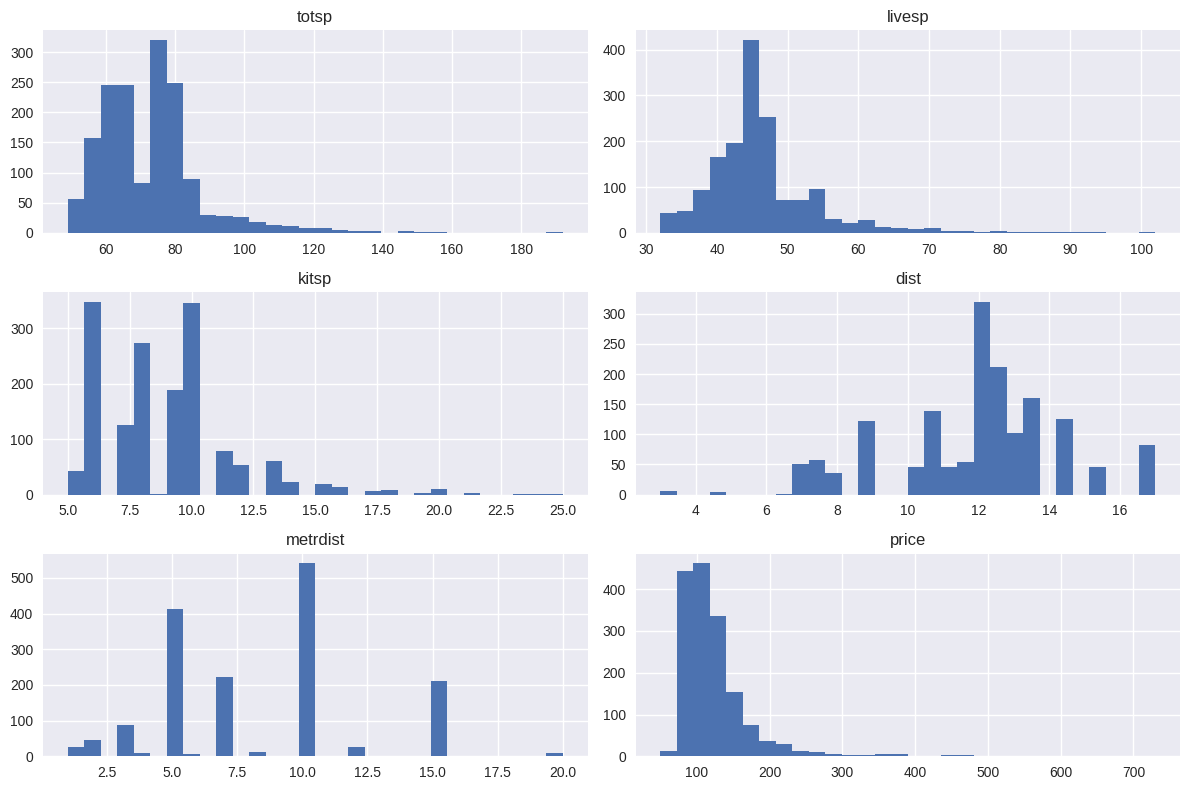

In [ ]:
numerical_features = ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']
categorical_features = ['walk', 'brick', 'floor', 'code']

plt.figure(figsize=(12, 8))
df[numerical_features + ['price']].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.savefig('distributions.png')
plt.show()

Ось Y - это кол-во квартир, подходящих под диапазон

**Вывод**: Большое количество квартир эконом класса (80-120 тыс долларов) , квартир с меньшей площадью, со средним значением от центра и средним значеним дистанции от метро

### 2.4. Проверка выбросов


<Axes: xlabel='dist', ylabel='price'>

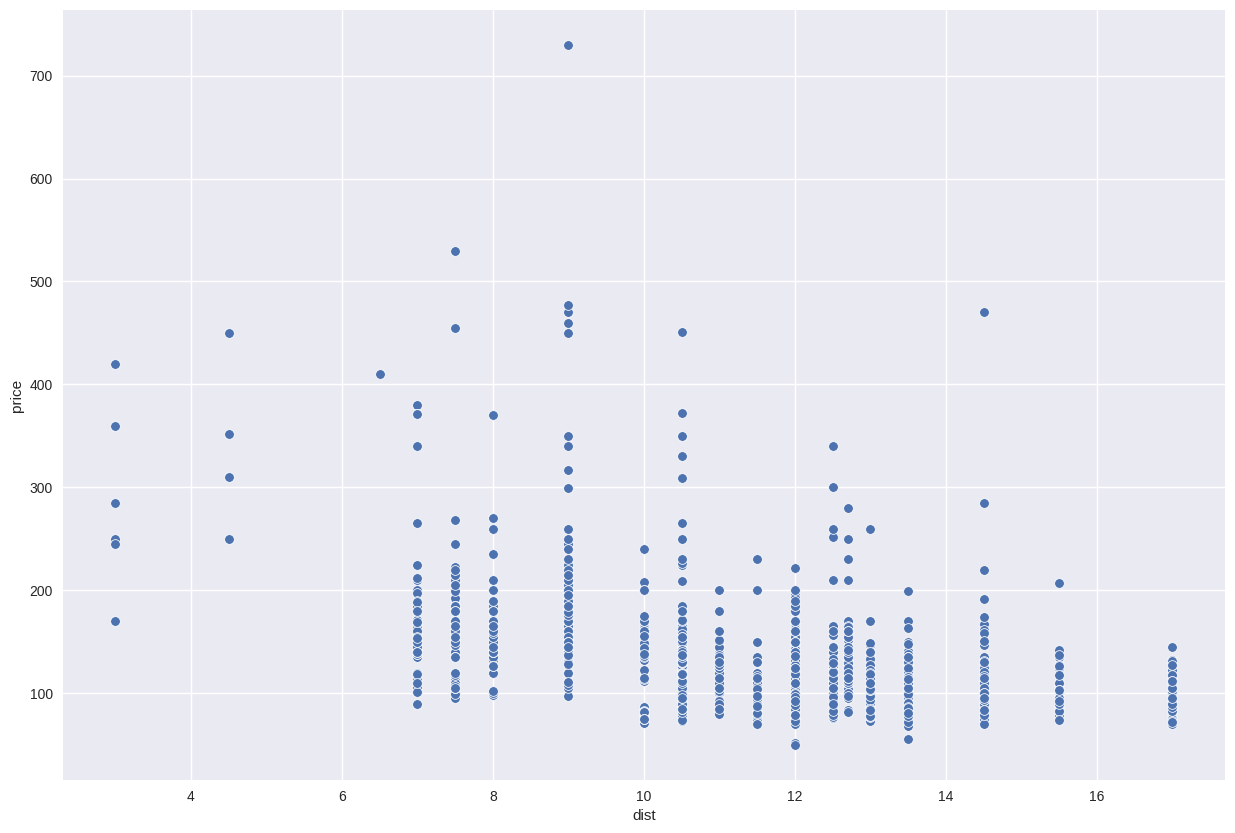

In [ ]:

plt.figure(figsize=(15,10))
sns.scatterplot(x=df.dist, y=df.price)

In [ ]:
df.query('(400 < price < 500) & (14 < dist < 15)')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,class
695,470,146,86,16.0,14.5,5,1,1,1,3,3


In [ ]:

df = df[df.price < 600] #оставляет строки, у которых цена <60 (т.е. избавляемся от 1 выброса)
df = df.drop(df.index[695]).reset_index() #удаляем 2 вброс по индексу, который нашли ранее

<Axes: xlabel='dist', ylabel='price'>

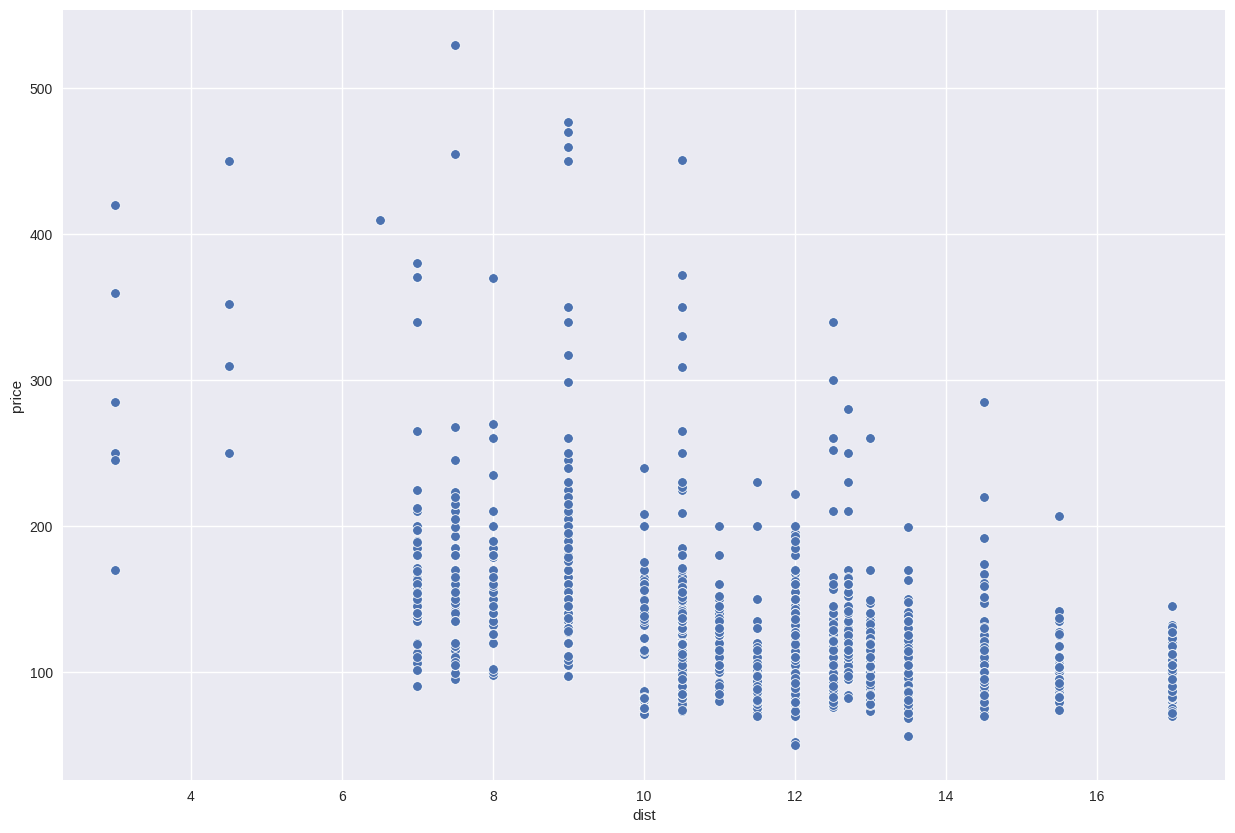

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.dist, y=df.price)

In [ ]:
df

,index,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,class
0,0,81,58,40,6.0,12.5,7,1,1,1,3,1
1,1,95,61,37,6.0,13.5,7,1,0,1,1,2
2,2,330,104,60,11.0,10.5,7,0,1,1,3,3
3,3,137,76,50,9.0,11.0,7,1,1,1,8,3
4,4,225,80,56,9.0,9.0,5,1,1,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1602,1604,110,77,47,10.0,13.0,10,1,0,1,5,1
1603,1605,110,77,45,10.0,12.0,5,0,0,1,5,1
1604,1606,95,60,46,5.0,10.5,5,1,0,1,7,2
1605,1607,129,76,48,10.0,12.5,5,0,0,1,3,2


In [ ]:
# Удаление ненужного столбца (индекс)
df.drop(df.columns[0], axis=1, inplace=True)

In [ ]:
df

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,class
0,81,58,40,6.0,12.5,7,1,1,1,3,1
1,95,61,37,6.0,13.5,7,1,0,1,1,2
2,330,104,60,11.0,10.5,7,0,1,1,3,3
3,137,76,50,9.0,11.0,7,1,1,1,8,3
4,225,80,56,9.0,9.0,5,1,1,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...
1602,110,77,47,10.0,13.0,10,1,0,1,5,1
1603,110,77,45,10.0,12.0,5,0,0,1,5,1
1604,95,60,46,5.0,10.5,5,1,0,1,7,2
1605,129,76,48,10.0,12.5,5,0,0,1,3,2


### 2.5. Анализ категориальных признаков
Исследуем влияние категориальных признаков на цену и распределение классов.

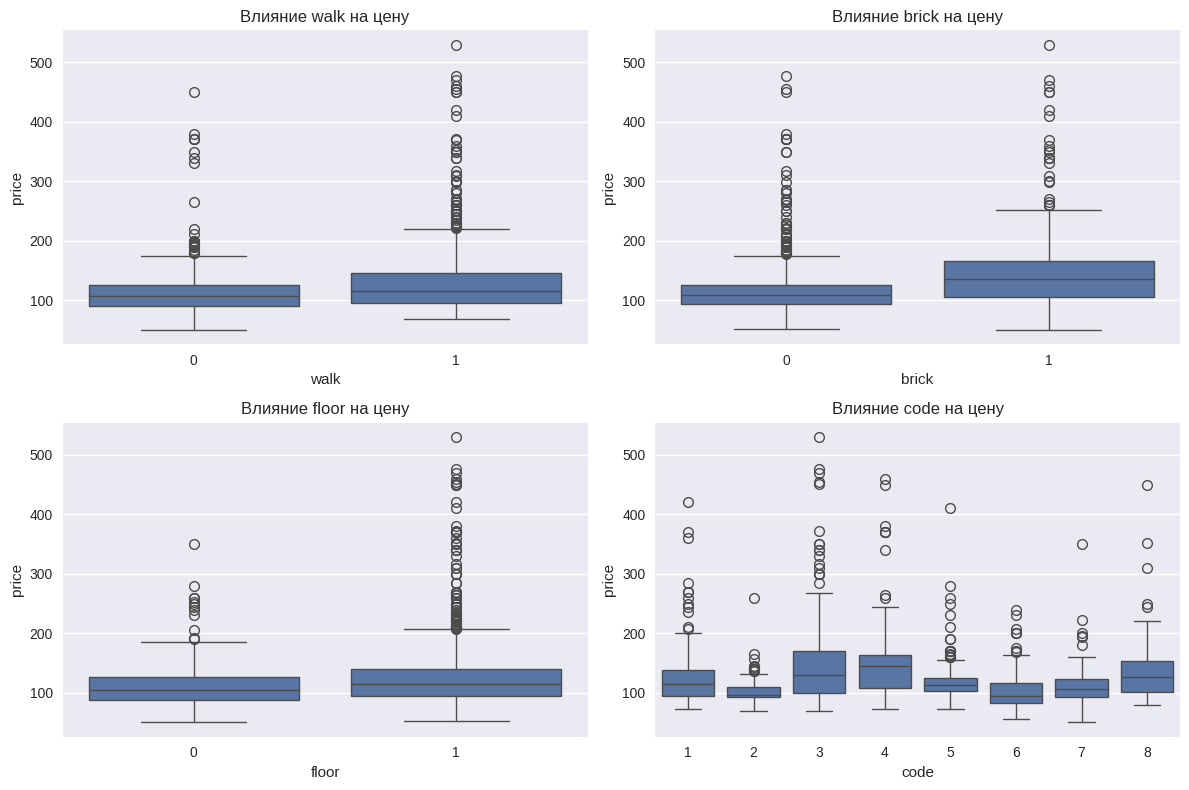

In [ ]:
plt.figure(figsize=(12, 8))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=feature, y='price', data=df)
    plt.title(f'Влияние {feature} на цену')
plt.tight_layout()
plt.savefig('categorical_vs_price.png')
plt.show()

Квартиры с доступом пешком до метро (walk = 1) дороже в среднем и имеют больший диапазон цен, что логично — близость к метро повышает стоимость.

Кирпичные квартиры (brick = 1) дороже в среднем, и их стоимость может быть выше из-за качества строительства или престижа. Выбросы говорят о редких элитных объектах.

Квартиры на первом этаже (floor = 0) дешевле в среднем, что связано с
меньшей популярностью.

Цены зависят от района. Коды 1, 2, 3 (1. Север, около Калужско-Рижской линии метро
    2. Север, около Серпуховско-Тимирязевской линии метро
    3. Северо-запад, около Замоскворецкой линиии метро) дороже, с большим разнообразием цен. Коды 6, 7, 8 (6. Юго-восток, около Таганско-Краснопресненской линиии метро
    7. Восток, около Калининской линиии метро
    8. Восток, около Арбатско-Покровской линиии метро) дешевле и более однородны по стоимости

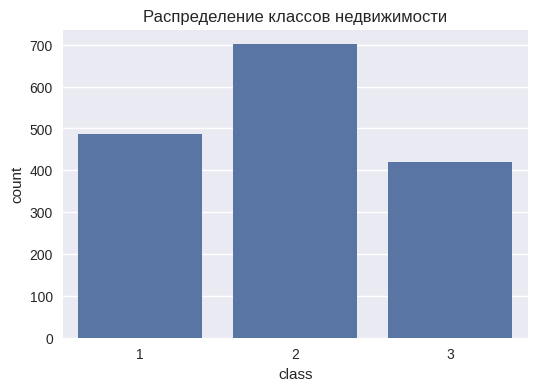

In [ ]:
# Распределение классов
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title('Распределение классов недвижимости')
plt.savefig('class_distribution.png')
plt.show()

**Вывод**: Дисбаланс классов учтен через `class_weight='balanced'` в модели.

### 2.6. Корреляционный анализ
Анализируем корреляцию числовых признаков с ценой.

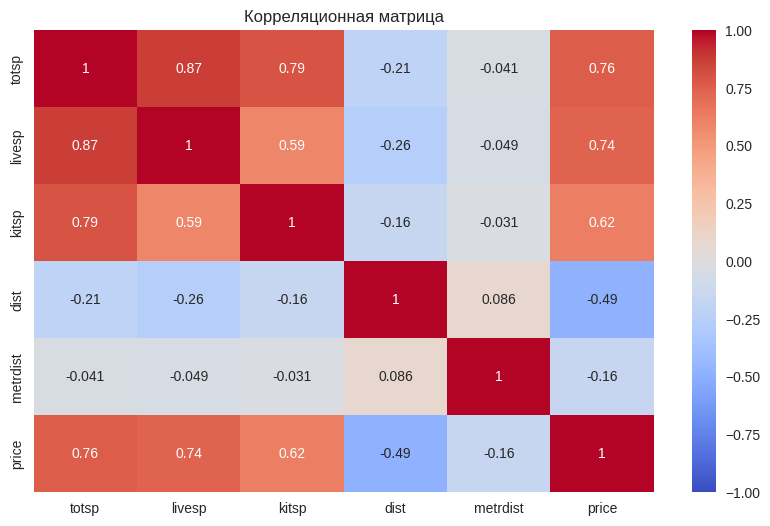

In [ ]:
corr_matrix = df[numerical_features + ['price']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица')
plt.savefig('correlation_matrix.png')
plt.show()

### 3.1. Обработка категориальных признаков
Кодируем номинальный признак `code` с помощью one-hot encoding.

In [ ]:
df = pd.get_dummies(df, columns=['code'], prefix='code')
categorical_features.remove('code')
categorical_features.extend([col for col in df.columns if col.startswith('code_')])

### 3.2. Разделение данных
Разделяем данные на признаки и целевые переменные.

In [ ]:


X = df.drop(['price', 'class'], axis=1)
y_price = df['price']
y_class = df['class']
X_train, X_test, y_train_price, y_test_price = train_test_split(X, y_price, test_size=0.2, random_state=42)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)


### 3.3. Масштабирование числовых признаков
Создаем пайплайн для масштабирования.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_train_class = preprocessor.fit_transform(X_train_class)
X_test_class = preprocessor.transform(X_test_class)

## 4. Обучение моделей

### 4.1. Регрессия
Сравниваем три модели: Random Forest, Gradient Boosting и Linear Regression.

In [ ]:
# Определение моделей
reg_models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression()
}

# Оценка моделей с помощью кросс-валидации
print("\nКросс-валидация для регрессии:")
for name, model in reg_models.items():
    scores = cross_val_score(model, X_train, y_train_price, cv=5, scoring='r2')
    print(f"{name}: R² = {scores.mean():.4f} ± {scores.std():.4f}")

# Подбор гиперпараметров для Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train_price)
best_reg = grid_rf.best_estimator_
print("\nЛучшие параметры RandomForest:", grid_rf.best_params_)


Кросс-валидация для регрессии:
RandomForest: R² = 0.7626 ± 0.0554
GradientBoosting: R² = 0.7579 ± 0.0607
LinearRegression: R² = 0.7377 ± 0.0414

Лучшие параметры RandomForest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


### 4.2. Классификация
Сравниваем две модели: Random Forest и Gradient Boosting. Используем `class_weight='balanced'`

In [ ]:
# Определение моделей
clf_models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# Оценка моделей с помощью кросс-валидации
print("\nКросс-валидация для классификации:")
for name, model in clf_models.items():
    scores = cross_val_score(model, X_train_class, y_train_class, cv=5, scoring='accuracy')
    print(f"{name}: Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")

# Подбор гиперпараметров для Random Forest
param_grid_clf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_clf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid_clf, cv=5, scoring='accuracy', n_jobs=-1)
grid_clf.fit(X_train_class, y_train_class)
best_clf = grid_clf.best_estimator_
print("\nЛучшие параметры RandomForestClassifier:", grid_clf.best_params_)


Кросс-валидация для классификации:
RandomForest: Accuracy = 0.6778 ± 0.0262
GradientBoosting: Accuracy = 0.6802 ± 0.0182

Лучшие параметры RandomForestClassifier: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


## 5. Оценка моделей

### 5.1. Регрессия
Оцениваем лучшую модель (Random Forest) на тестовом наборе.


Метрики регрессии:
R²: 0.8093
MSE: 356.9741


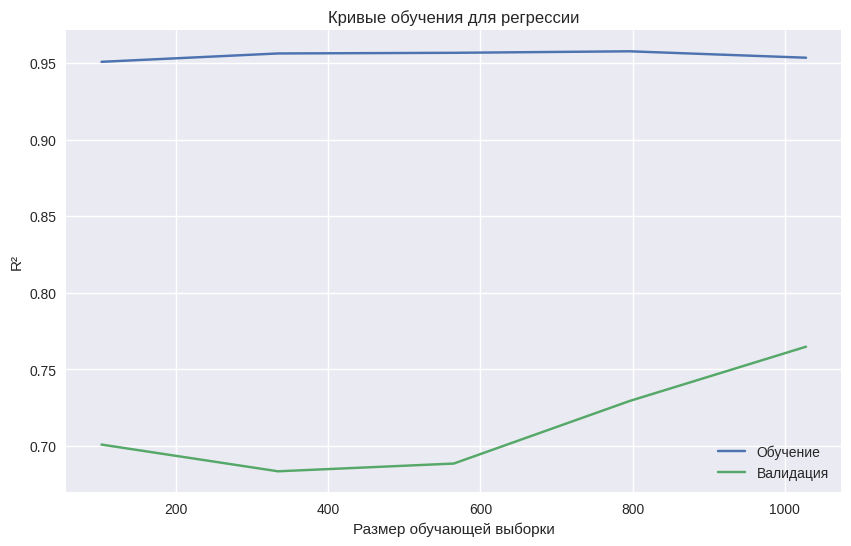

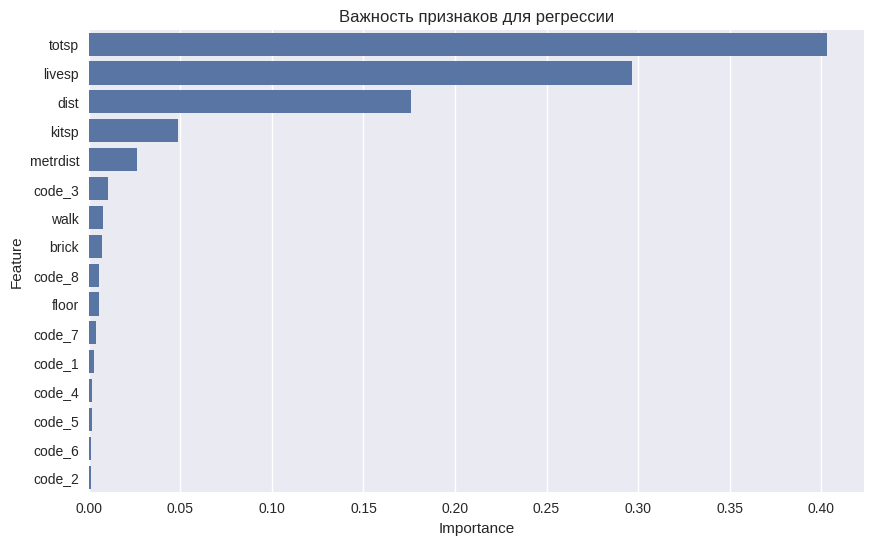

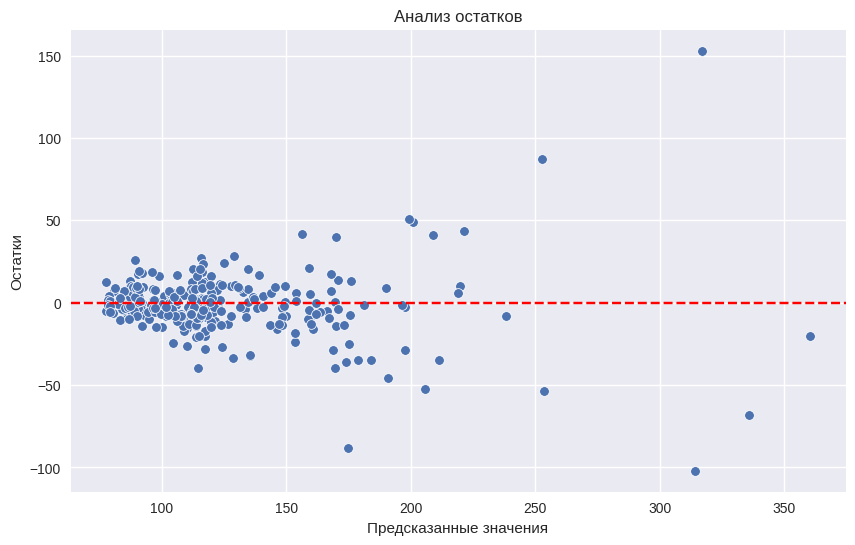

In [ ]:
y_pred_price = best_reg.predict(X_test)

# Метрики
r2 = r2_score(y_test_price, y_pred_price)
mse = mean_squared_error(y_test_price, y_pred_price)
print("\nМетрики регрессии:")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")

# Кривые обучения
train_sizes, train_scores, test_scores = learning_curve(best_reg, X_train, y_train_price, cv=5, scoring='r2', n_jobs=-1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Обучение')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Валидация')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('R²')
plt.title('Кривые обучения для регрессии')
plt.legend()
plt.savefig('reg_learning_curve.png')
plt.show()

# Важность признаков
feature_names = numerical_features + categorical_features
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_reg.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Важность признаков для регрессии')
plt.savefig('feature_importance_reg.png')
plt.show()

# Анализ остатков
residuals = y_test_price - y_pred_price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_price, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Анализ остатков')
plt.savefig('residuals.png')
plt.show()

### 5.2. Классификация
Оцениваем лучшую модель (Random Forest) на тестовом наборе.


Метрики классификации:
Accuracy: 0.6863

Classification Report:
              precision    recall  f1-score   support

      Эконом       0.55      0.64      0.59        87
     Комфорт       0.68      0.64      0.66       148
      Бизнес       0.86      0.80      0.83        87

    accuracy                           0.69       322
   macro avg       0.70      0.70      0.70       322
weighted avg       0.70      0.69      0.69       322



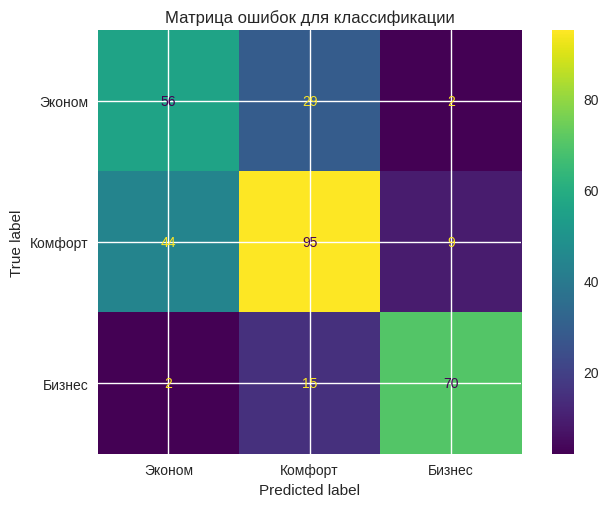

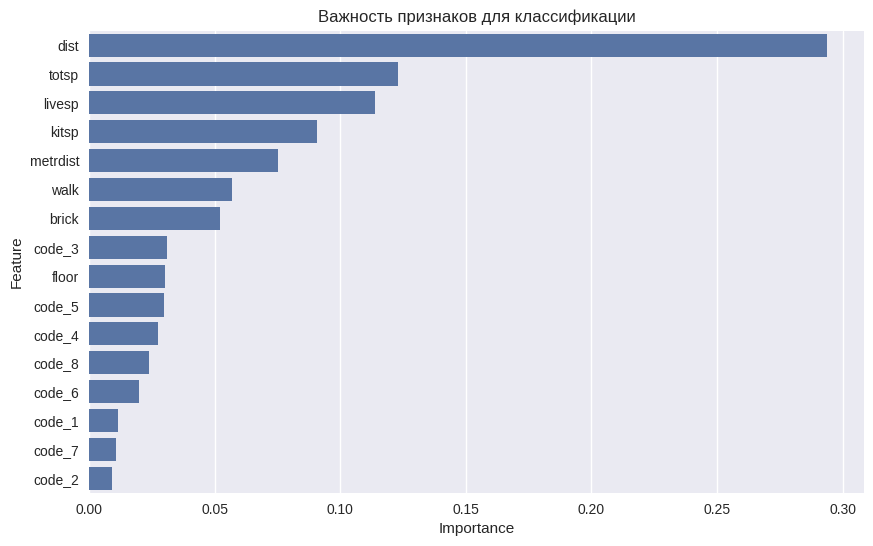

In [ ]:
y_pred_class = best_clf.predict(X_test_class)

# Метрики
accuracy = accuracy_score(y_test_class, y_pred_class)
print("\nМетрики классификации:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class, target_names=['Эконом', 'Комфорт', 'Бизнес']))

# Матрица ошибок
cm = confusion_matrix(y_test_class, y_pred_class)
ConfusionMatrixDisplay(cm, display_labels=['Эконом', 'Комфорт', 'Бизнес']).plot()
plt.title('Матрица ошибок для классификации')
plt.savefig('confusion_matrix.png')
plt.show()

# Важность признаков
feature_importance_clf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_clf)
plt.title('Важность признаков для классификации')
plt.savefig('feature_importance_clf.png')
plt.show()

## 6. Обучение модели с помощью CNN

### 6.1. Регрессия

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import numpy as np
import pandas as pd

X = df.drop(['price', 'class'], axis=1)
y_price = df['price']
y_class = df['class']
X_train, X_test, y_train_price, y_test_price = train_test_split(X, y_price, test_size=0.2, random_state=42)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)


y_train_price = pd.to_numeric(y_train_price, errors='coerce').astype('float32')
y_test_price = pd.to_numeric(y_test_price, errors='coerce').astype('float32')


if y_train_price.isna().any() or y_test_price.isna().any():
    print("NaN values found in y_train_price or y_test_price. Dropping NaN rows.")
    train_mask = ~y_train_price.isna()
    test_mask = ~y_test_price.isna()
    X_train = X_train[train_mask]
    y_train_price = y_train_price[train_mask]
    X_test = X_test[test_mask]
    y_test_price = y_test_price[test_mask]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 6. Обучение сверточной нейронной сети (CNN)
# Подготовка данных для CNN
min_features = 5
if X_train.shape[1] < min_features:
    raise ValueError(f"Number of features ({X_train.shape[1]}) is too small for Conv1D architecture. Need at least {min_features}.")

X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Модель CNN для регрессии
def build_cnn_regression(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Выход для регрессии
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Создаем и обучаем модель
cnn_reg = build_cnn_regression((X_train_cnn.shape[1], 1))
history_reg = cnn_reg.fit(X_train_cnn, y_train_price, epochs=50, batch_size=32,
                         validation_data=(X_test_cnn, y_test_price), verbose=0)

# Оценка модели регрессии
y_pred_cnn_price = cnn_reg.predict(X_test_cnn).flatten()
mse_cnn = mean_squared_error(y_test_price, y_pred_cnn_price)
r2_cnn = r2_score(y_test_price, y_pred_cnn_price)
print("\nМетрики CNN регрессии:")
print(f"MSE: {mse_cnn:.4f}")
print(f"R²: {r2_cnn:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Метрики CNN регрессии:
MSE: 407.3004
R²: 0.7824


### 6.2. Классификация


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Метрики CNN классификации:
Accuracy: 0.6801

Classification Report:
              precision    recall  f1-score   support

      Эконом       0.56      0.53      0.54        87
     Комфорт       0.67      0.68      0.67       148
      Бизнес       0.81      0.84      0.82        87

    accuracy                           0.68       322
   macro avg       0.68      0.68      0.68       322
weighted avg       0.68      0.68      0.68       322



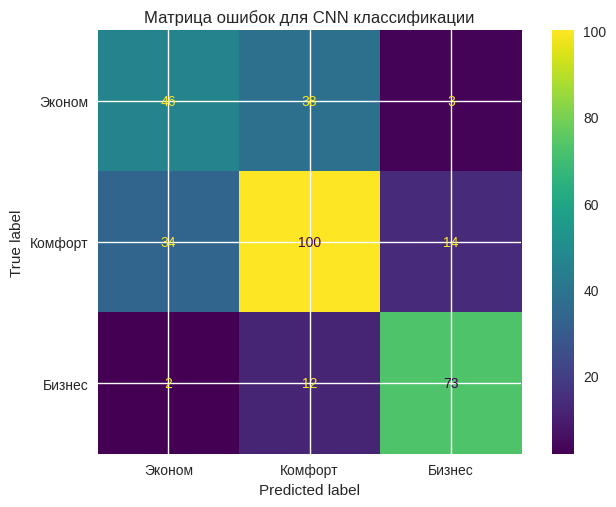

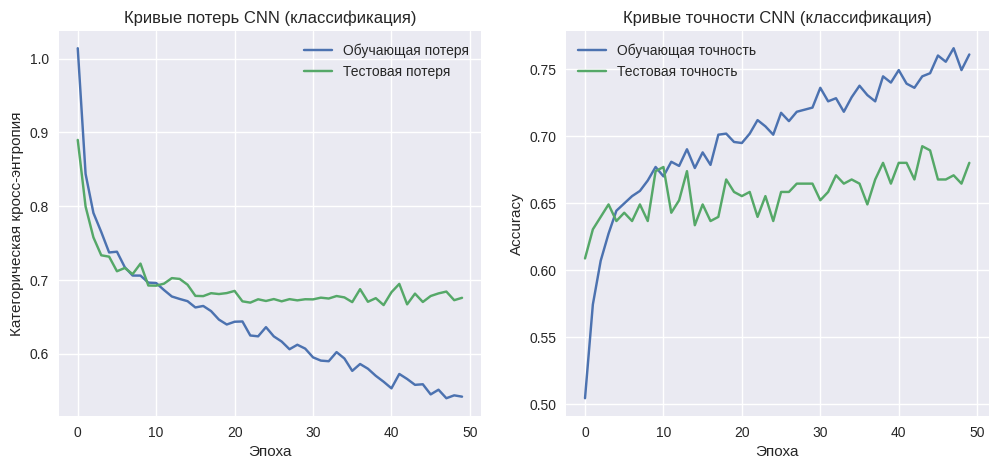

In [ ]:
# CNN для классификации
y_train_class_cat = to_categorical(y_train_class - 1)
y_test_class_cat = to_categorical(y_test_class - 1)

# Модель CNN для классификации
def build_cnn_classification(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Создаем и обучаем модель
cnn_clf = build_cnn_classification((X_train_cnn.shape[1], 1))
history_clf = cnn_clf.fit(X_train_cnn, y_train_class_cat, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test_class_cat), verbose=0)

# Оценка модели классификации
y_pred_cnn_class = cnn_clf.predict(X_test_cnn).argmax(axis=1) + 1
accuracy_cnn = accuracy_score(y_test_class, y_pred_cnn_class)
print("\nМетрики CNN классификации:")
print(f"Accuracy: {accuracy_cnn:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_cnn_class, target_names=['Эконом', 'Комфорт', 'Бизнес']))

# Матрица ошибок
cm_cnn = confusion_matrix(y_test_class, y_pred_cnn_class)
ConfusionMatrixDisplay(cm_cnn, display_labels=['Эконом', 'Комфорт', 'Бизнес']).plot()
plt.title('Матрица ошибок для CNN классификации')
plt.savefig('confusion_matrix_cnn.png')
plt.show()

# Визуализация кривых обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_clf.history['loss'], label='Обучающая потеря')
plt.plot(history_clf.history['val_loss'], label='Тестовая потеря')
plt.title('Кривые потерь CNN (классификация)')
plt.xlabel('Эпоха')
plt.ylabel('Категорическая кросс-энтропия')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_clf.history['accuracy'], label='Обучающая точность')
plt.plot(history_clf.history['val_accuracy'], label='Тестовая точность')
plt.title('Кривые точности CNN (классификация)')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('cnn_classification_curves.png')
plt.show()

## 7. Предсказание для новой квартиры

### 7.1. Подготовка данных
Создаем данные для новой квартиры и преобразуем их.

In [ ]:
# 7. Предсказание для новой квартиры
# Подготовка данных
new_flat = pd.DataFrame({
    'totsp': [68],
    'livesp': [47],
    'kitsp': [7],
    'dist': [15],
    'metrdist': [5],
    'walk': [1],
    'brick': [1],
    'floor': [0],
    'code': [3]
})

# Кодирование code
new_flat = pd.get_dummies(new_flat, columns=['code'], prefix='code')
for col in [col for col in df.columns if col.startswith('code_')]:
    if col not in new_flat.columns:
        new_flat[col] = 0
new_flat = new_flat[X.columns]  # Убедимся, что порядок столбцов совпадает
new_flat_transformed = preprocessor.transform(new_flat)
new_flat_cnn = new_flat_transformed.reshape(1, new_flat_transformed.shape[1], 1)

# Предсказание с помощью CNN
predicted_cnn_price = cnn_reg.predict(new_flat_cnn)[0][0]
predicted_cnn_class = cnn_clf.predict(new_flat_cnn).argmax(axis=1)[0] + 1
class_mapping = {1: 'Эконом', 2: 'Комфорт', 3: 'Бизнес'}
exchange_rate = 80.22  # Средний курс USD/RUB на май 2025

print("\nПредсказание для новой квартиры (CNN):")
print(f"Рекомендуемая цена (в рублях, курс {exchange_rate}): {(predicted_cnn_price * 1000 * exchange_rate).round(1)}")
print(f"Предсказанный класс: {class_mapping[predicted_cnn_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Предсказание для новой квартиры (CNN):
Рекомендуемая цена (в рублях, курс 80.22): 8071261.0
Предсказанный класс: Эконом


In [ ]:
similar_flats = df[
    (df['totsp'].between(66, 68)) &
    (df['livesp'].between(40, 49)) &
    (df['dist'].between(10, 16)) &
    (df['code_3']) & # Добавлено условие для code == 3
    (df['brick']==1) &
    (df['walk']==1)
]

# Проверка, что similar_flats не пуст
if not similar_flats.empty:
    avg_price = similar_flats['price'].mean() * 1000 * exchange_rate
    most_common_class = class_mapping[similar_flats['class'].mode()[0] - 1]  # Корректировка для 0-based
    print("\nСредняя цена похожих квартир (в рублях):", round(avg_price, 1))
    print("Наиболее частый класс похожих квартир:", most_common_class)
else:
    print("\nНет похожих квартир, удовлетворяющих заданным критериям.")


Средняя цена похожих квартир (в рублях): 8824200.0
Наиболее частый класс похожих квартир: Эконом
